In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

## 1. Problem statement

In the simplest determenistic setting, we seek to minimize a smooth real-valued function $f: \mathbb{R} \rightarrow \mathbb{R}$ without constraints.

The goal is to solve 
$$\min_{x \in \mathbb{R}^n} f(x)$$
using evaluations of $f(x)$, its gradient $\nabla f(x)$ and for second-order methods the Hessian $\nabla^2 f(x)$.

Many modern ML optimization methods build on classical determenistic methods. Therefore, implementing these algorithms from scratch, varifying their convergence and comparing there empirical behaviour is crucial for understanding more complex methods and being aware of limitations.

## 2. Goal of the notebook

The goal of this work is to:

1. Implement from scratch fundamental deterministic optimization algorithms, such as:
    - Gradient Descent (GD)
    - Gradien Descent with Backtracking Search
    - Heavy-Ball Momentum
    - Newton's method with Backtracking

2. Provide theory for:
    - Update rule
    - Assumptions guaranteeing convergence
    - Convergence rate

3. Vusualize optimization dynamics on a 2-dimensional quadratic function via countour trajectories and convergence-rate plots

4. Demonstrate hyperparameter selection

5. Evaluate and compare each method both theoretically and empirically

## 3. Theory of Optimization Methods with implementation

First, let's determine the function we want to minimize. In our case it is $f(x, y) = ax^2 + by^2$, where $a, b \in \mathbb{R}$. Also there will be determined gradient and hessian for a picked quadratic function.

In [8]:
def f(p, a=1.0, b=20.0):
    x, y = p[...,0], p[...,1]
    return a * x**2 + b * y**2

def grad_f(p, a=1.0, b=20.0):
    x, y = p
    return np.array([2*a*x, 2*b*y])

def hessian_f(a=1.0, b=20.0):
    return np.array([[2*a, 0], [0, 2*b]])

### 3.1 Gradient Descent (Fixed Learning Rate)

**Update rule**

Given a differentiable function $f$, GD uses iteration $x_{k+1} = x_k - \alpha \nabla f(x_k)$, where $\alpha > 0$ is the step size.

In [9]:
def gradient_descent(x0, grad_fn, lr=0.05, steps=200):
    x = x0.copy()
    traj = [x.copy()]
    for k in range(steps):
        x = x - lr * grad_fn(x)
        traj.append(x.copy())
    return np.array(traj)

**Convergence assumptions**

GD converges to the minimizer $x^*$ under 

1. L-smoothness: $\quad \|\nabla f(x) - \nabla f(y)\| \leqslant L \|x-y\|$
    
2. Strong convexity with $\mu > 0$: $\quad f(y) \geqslant f(x) +\nabla f(x)^{T}(y-x) + \dfrac{\mu}{2}\|x-y\|^{2}$.

**Convergence rate**

If $\alpha = \dfrac{1}{L}$, GD converges linearly: $\quad \|x_{k} - x^{*} \| \leqslant \left(1-\dfrac{\mu}{L} \right)^k \|x_{0} - x^{*} \|$, $\quad$ where $x^{*} = arg\min_{x \in \mathbb{R}^n} f(x)$

### 3.2 Gradient Descent with Backtracking (Armijo line search)

Given parameters $\beta, \tau, c \in (0,1)$

**Update rule**

1. Starting with $\alpha = \beta$
2. Armijo condition: $\quad f(x - \alpha \nabla f(x)) \le f(x) - c\alpha \|\nabla f(x)\|^2$

reducing the step $\tilde{\alpha} = \tau \alpha$

3. Updating argument: $\quad x_{k+1} = x_{k} - \tilde{\alpha} \nabla f(x_{k})$.


In [10]:
def backtracking_armijo(x, grad_fn, f_fn, alpha0=1.0, rho=0.5, c=1e-4):
    g = grad_fn(x)
    alpha = alpha0
    fx = f_fn(x)

    while f_fn(x - alpha * g) > fx - c * alpha * np.dot(g, g):
        alpha *= rho
        if alpha < 1e-12:
            break
    return alpha

def gd_backtracking(x0, grad_fn, f_fn, alpha0=1.0, rho=0.5, c=1e-4, steps=100):
    x = x0.copy()
    traj = [x.copy()]
    for k in range(steps):
        g = grad_fn(x)
        alpha = backtracking_armijo(x, grad_fn, f_fn, alpha0, rho, c)
        x = x - alpha * g
        traj.append(x.copy())
    return np.array(traj)


**Convergence assumptions**

1. $f$ is differentiable

2. $\nabla f$ is Lipschitz continuous with constant L

3. level sets of $f$ are bounded 

4. $f$ is $\mu$-strongly convex for strong convergence results

**Convergence guarantees**

1. For general convex f backtracking GD achieves the standart sublinear rate $\quad f(x_{k}) - f(x^{*}) = O \left(\dfrac{1}{k} \right)$.

2. For strongly convex f the method converges linearly: $\quad \|x_{k}-x^{*}\| \leqslant C p^{k}$, where $p \in (0,1)$.

Unlike fixed-step GD we don't need $\alpha = \dfrac{1}{L}$, the algorithm automatically finds a suitable step size and convergence is guaranteed from any starting point.

### 3.3 Heavy-Ball Momentum (Polyak)

**Update rule**

$x_{k+1} = x_k - \alpha \nabla f(x_{k}) + \beta (x_{k} - x_{k-1})$.

Momentum reduces oscillations in valleys by smoothing gradients, but requires careful tuning.

In [11]:
def momentum(x0, grad_fn, lr=0.1, beta=0.8, steps=200):
    x = x0.copy()
    v = np.zeros_like(x)
    traj = [x.copy()]
    for k in range(steps):
        g = grad_fn(x)
        v = beta * v + g
        x = x - lr * v
        traj.append(x.copy())
    return np.array(traj)


**Convergence**

If $f$ is strongly convex and smooth, convergence is linear when parameters are tuned to problem curvature

$\alpha = \dfrac{4}{(\sqrt{L} + \sqrt{\mu})^2}, \quad \beta = \left(\dfrac{\sqrt{L} - \sqrt{\mu}}{\sqrt{L} + \sqrt{\mu}} \right)^2$.

Improper tuning can cause divergence or oscillations.

### 3.4 Newton’s Method

**Update rule** 

$x_{k+1} = x_k - H^{-1}(x_k)\,\nabla f(x_k)$.

For a quadratic function $\quad f(x) = \frac12 x^T H x \quad$ Newton's method converges in one iteration, 

because a step $p = H^{-1} g = x$ and $x_{k+1} = x_k - x_k = 0$.

This demonstrates a power of the second order methods.

In [12]:
def newton_method(x0, grad_fn, hessian_fn, steps=5):
    x = x0.copy()
    traj = [x.copy()]
    for k in range(steps):
        g = grad_fn(x)
        H = hessian_fn()
        p = np.linalg.solve(H, g)
        x = x - p
        traj.append(x.copy())
    return np.array(traj)

However for non-quadratic or not smooth problems backtracking is necessary.

### 3.5 Newton's method with Backtracking line search

**Update rule**

$x_{k+1} = x_{k} - t_{k}\left(\nabla^{2}f(x_{k}) \right)^{-1}\nabla f(x_{k})$, where $t_{k}$ is chosen by backtracking.

**Convergence**

If close to the minimizer there is a quadratic convergence: $\quad \|x_{k+1}-x^{*}\| \leqslant C \|x_{k}-x^{*}\|^2$.

Far from the optimum, the method behaves like first-order gradient methods until sufficient curvature is detected. Even with poor initialization backtracking ensures global convergence.

## 4. Visualization

Let's determine helful visualization functions

In [13]:
def make_mesh(xlim=(-3,3), ylim=(-3,3), n=300, a=1, b=20):
    xs = np.linspace(*xlim, n)
    ys = np.linspace(*ylim, n)
    X, Y = np.meshgrid(xs, ys)
    Z = a*X**2 + b*Y**2
    return X, Y, Z

def plot_contours_with_traj(traj_list, labels, a=1, b=20, xlim=(-3,3), ylim=(-3,3)):
    X, Y, Z = make_mesh(xlim, ylim, n=400, a=a, b=b)
    plt.figure(figsize=(7,7))
    plt.contour(X, Y, Z, levels=np.logspace(-2,3,40), norm=LogNorm(), cmap='coolwarm')
    for traj, lab in zip(traj_list, labels):
        plt.plot(traj[:,0], traj[:,1], '-o', markersize=3, label=lab)
    plt.scatter([0],[0], marker='x', color='k')
    plt.legend()
    plt.title("Trajectories on contour plot")
    plt.show()

def plot_convergence(traj_list, labels, a=1, b=20):
    plt.figure(figsize=(12,4))
    for traj, lab in zip(traj_list, labels):
        fvals = np.array([f(x,a,b) for x in traj])
        plt.semilogy(fvals, label=lab)
    plt.grid()
    plt.title("Convergence (f(x_k))")
    plt.ylim(1e-10, 1e3)
    plt.legend()
    plt.show()

Getting trajectories of itrerations from each method and marking them down on a contour plot.

In [14]:
x0 = np.array([2.5, 2.5])

traj_gd = gradient_descent(x0, lambda x: grad_f(x,1,20), lr=0.045)
traj_bt = gd_backtracking(x0, lambda x: grad_f(x,1,20), lambda x: f(x,1,20))
traj_mom = momentum(x0, lambda x: grad_f(x,1,20), lr=0.01, beta=0.9)
traj_newt = newton_method(x0, lambda x: grad_f(x,1,20), lambda: hessian_f(1,20))

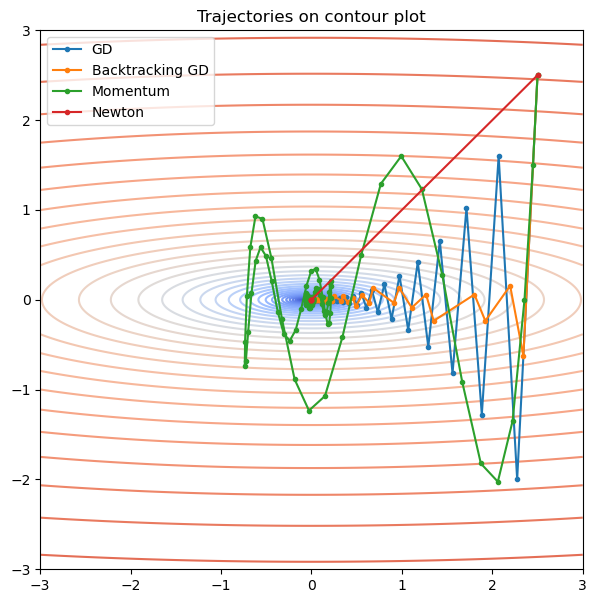

In [15]:
plot_contours_with_traj([traj_gd, traj_bt, traj_mom, traj_newt], ["GD", "Backtracking GD", "Momentum", "Newton"])

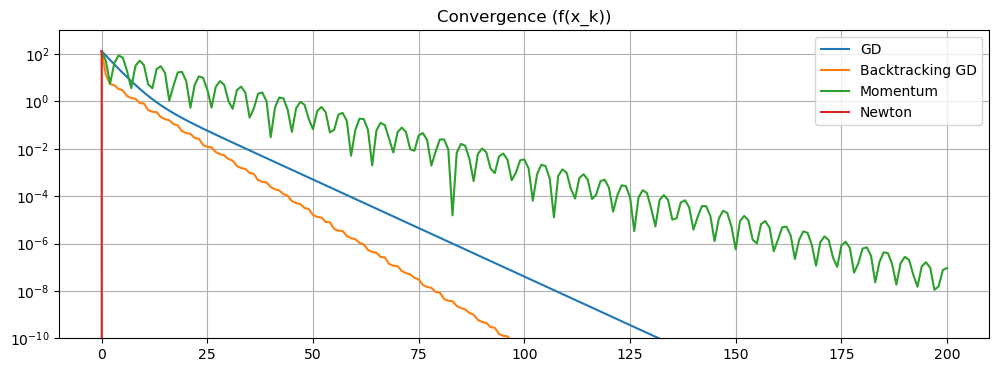

In [16]:
plot_convergence([traj_gd, traj_bt, traj_mom, traj_newt], ["GD", "Backtracking GD", "Momentum", "Newton"])

### 5. Hyperparameter tuning for GD with Momentum

Our goal here is to minimize number of iterations to convergence and make method more stable with avoiding oscillations.

Grid search for $\alpha, \beta$ will be used to achieve this goal.

In [44]:
def tune_momentum(x0, alphas=[0.001, 0.01, 0.05, 0.1, 0.2], betas=[0.5, 0.7, 0.9, 0.95]):
    results = []
    
    for alpha in alphas:
        for beta in betas:
            xs = momentum(x0, lambda x: grad_f(x,1,20), lr=alpha, beta=beta)
            f_final = f(xs[-1])
            results.append({
                "alpha": alpha,
                "beta": beta,
                "f_final": f_final
            })
    
    return results



C:\Users\danisemo\AppData\Local\Temp\ipykernel_20124\300555534.py:3: RuntimeWarning: overflow encountered in square
  return a * x**2 + b * y**2


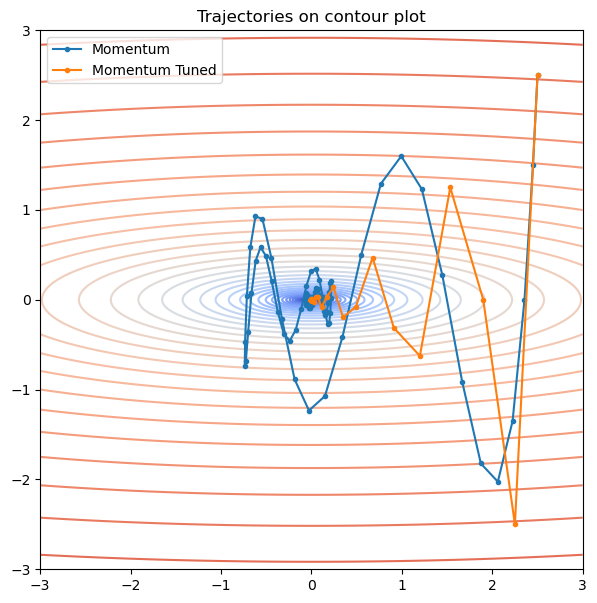

In [45]:
results = tune_momentum(x0)

results_sorted = sorted(results, key=lambda r: r["f_final"])

traj_mom = momentum(x0, lambda x: grad_f(x,1,20), lr=0.01, beta=0.9)
traj_mom_tuned = momentum(x0, lambda x: grad_f(x,1,20), lr=results_sorted[0]["alpha"], beta=results_sorted[0]["beta"])
plot_contours_with_traj([traj_mom, traj_mom_tuned], ["Momentum", "Momentum Tuned"])


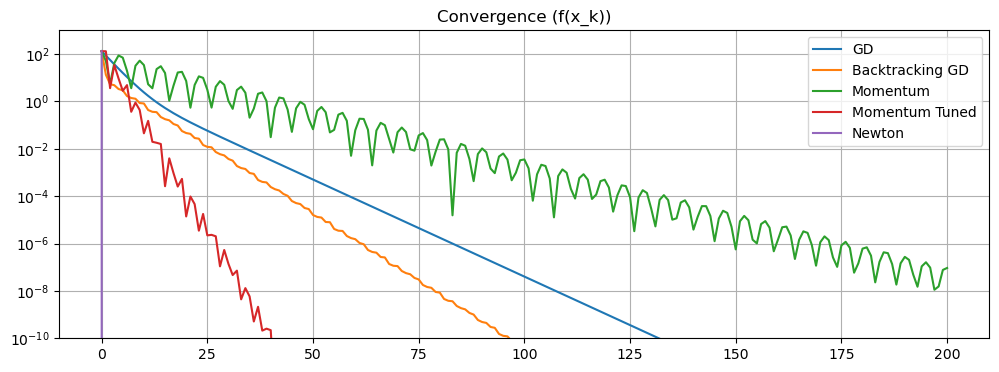

In [46]:
plot_convergence([traj_gd, traj_bt, traj_mom, traj_mom_tuned, traj_newt], ["GD", "Backtracking GD", "Momentum", "Momentum Tuned", "Newton"])

**Conclusions**
- Gradient Descent is a simple and stable method but slower than other methods;
- Gradient Descent with Backtracking is the most effective and robust among first-order methods, with clean convergence behaviour and no need for hyperparameter tuning;
- Gradient Descent with Momentum accelerates but introduces oscillations and converges slower than properly tuned GD;
- Newton's method is the fastest one, converging in a single iteration for a quadratic function.